In [1]:
import pandas as pd
import numpy as np
from data_mani.utils import merge_market_and_gtrends
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from prediction.util import new_r2, add_shift
from prediction.util import hyper_params_search
from prediction.util import get_selected_features
from prediction.models import RandomForestWrapper



from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import make_scorer
from IPython.display import display, HTML
from time import time
import os
from glob import glob

## Variables

In [2]:
tickers = ['0910150D US Equity', '1288652D US Equity',
           '1831877D US Equity', 'ANDV US Equity',
           'BCR US Equity', 'GR US Equity', 'HAR US Equity',
           'HAS US Equity', 'HPC US Equity', 'MAT US Equity',
           'NBL US Equity', 'TSS US Equity', 'TWX US Equity',
           'TXU US Equity', 'WAMUQ US Equity']

ticker_name =  tickers[3]
fs_method = "fake"
market_folder = "spx"
init = time()

# Get merged dataframe 

In [3]:
ticker_path = "data/index/{}/{}.csv".format(market_folder,ticker_name)
train, test = merge_market_and_gtrends(ticker_path, test_size=0.5)
train.shape, test.shape

((1856, 183), (1856, 183))

## Add shift + Preprocessing + Selecting Features

In [4]:
words = train.drop("target_return",1).columns.to_list()

add_shift(merged_df=train, words=words, max_lag=20)

if fs_method == "all":
    select = train.drop("target_return",1).columns.to_list()
else:
    select = get_selected_features(ticker_name=ticker_name,
                                   out_folder=market_folder,
                                   fs_method=fs_method)


train = train[["target_return"] + select]
train = train.fillna(0.0)

add_shift(merged_df=test, words=words, max_lag=20)
test = test[["target_return"] + select]
test = test.fillna(0.0)

add shift: 100%|██████████| 182/182 [00:36<00:00,  4.99it/s]


In [5]:
train.shape, test.shape

((1856, 2220), (1856, 2220))

# Hyperparameter search + Prediction

In [6]:
all_preds = []
complete = pd.concat([train, test])
years = list(set(complete.index.map(lambda x: x.year)))
years.sort()
years = years[:-1]

for y in tqdm(years, desc="anual training and prediction"):
    train_ys = complete[:str(y)]
    test_ys = complete[str(y+1)]
    rf_wrapper = RandomForestWrapper()
    test_size = train_ys.shape[0]//4
    model_search =  hyper_params_search(df=train_ys,
                                        wrapper=rf_wrapper,
                                        n_jobs=2,
                                        n_iter=1,
                                        test_size=test_size)
    X_test = test_ys.drop("target_return",1).values
    y_test = test_ys.target_return.values
    test_pred  = model_search.best_estimator_.predict(X_test)
    dict_ = {"date": test_ys.index,
             "return":y_test,
             "prediction":test_pred}
    result = pd.DataFrame(dict_)
    all_preds.append(result)


anual training and prediction:   0%|          | 0/14 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    1.2s finished
anual training and prediction:   7%|▋         | 1/14 [00:01<00:19,  1.48s/it][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.8s finished
anual training and prediction:  14%|█▍        | 2/14 [00:02<00:17,  1.47s/it][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:  1.0min finished
anual training and prediction:  21%|██▏       | 3/14 [02:05<06:56, 37.85s/it][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:  1.0min finished
anual training and prediction:  29%|██▊       | 4/14 [03:52<09:44, 58.43s/it][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.5s finished
anual training and prediction:  36%|███▌      | 5/14 [03:52<06:10, 41.15s/it][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.3s finished
anual training and prediction:  43%|████▎     | 6/14 [03:53<03:51, 28.99s/it][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.4s finished
anual training and prediction:  50%|█████     | 7/14 [03:54<02:23, 20.48s/it][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    1.6s finished
anual training and prediction:  57%|█████▋    | 8/14 [03:56<01:30, 15.11s/it][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:  2.5min finished
anual training and prediction:  64%|██████▍   | 9/14 [07:59<06:56, 83.28s/it][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:  1.1min finished
anual training and prediction:  71%|███████▏  | 10/14 [09:48<06:04, 91.14s/it][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    2.1s finished
anual training and prediction:  79%|███████▊  | 11/14 [09:52<03:14, 64.85s/it][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.4s finished
anual training and prediction:  86%|████████▌ | 12/14 [09:52<01:31, 45.62s/it][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    1.9s finished
anual training and prediction:  93%|█████████▎| 13/14 [09:55<00:32, 32.82s/it][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    4.5s finished
anual training and prediction: 100%|██████████| 14/14 [10:02<00:00, 43.06s/it]


# Saving the predictions

In [7]:
out_path = "results/forecast/{}/{}/{}.csv".format(fs_method,market_folder,ticker_name)
df = pd.concat(all_preds)
df.to_csv(out_path, index=False)

## Analysis

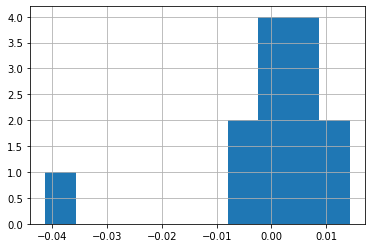

In [8]:
df = pd.concat(all_preds)
df.loc[:, "date"] = pd.to_datetime(df.date)
df = df.set_index("date")
all_r2 = []

for year in years[1:]:
    df_ =  df[str(year)]
    r2_ = new_r2(df_["return"].values, df_["prediction"].values)
    all_r2.append(r2_)
all_r2 = pd.Series(all_r2, index=years[1:])
all_r2.hist();

In [9]:
all_r2

2005    0.003634
2006   -0.041245
2007    0.010228
2008   -0.005609
2009    0.001095
2010    0.014295
2011    0.002598
2012    0.007624
2013    0.001980
2014    0.005269
2015    0.000750
2016   -0.006432
2017    0.005665
dtype: float64

In [10]:
tempo = (time() - init) / 60
print(np.round(tempo,2), "min")

11.4 min
